**Installing latest pickle to unserialize our data from database**

In [1]:
!pip install pickle5

     |████████████████████████████████| 133kB 22.3MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218610 sha256=84a033c1fe9108f679b701a535940fe3c8e7253d07c6d738de97c42d42d97aee
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


Connecting to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Adding needed imports**

In [6]:
import os
import  pickle5 as pickle
from HandReading import HandReading
from Imu import Imu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, GRU
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

**Creating dictionary mappers**


In [8]:
dict_word_id = {}
dict_id_word = {}

list_word = os.listdir('/content/drive/MyDrive/database') 
for j in range(len(list_word)) : 
  dict_word_id[list_word[j]] = j
  dict_id_word[j] = list_word[j]
print(dict_word_id)
print(dict_id_word)

{'oi': 0, 'tchau': 1, 'abdullah': 2, 'prazer-em-te-conhecer': 3, 'silencio': 4, 'lucas': 5, '23': 6, 'qual-seu-nome': 7, 'qual-a-sua-idade': 8, 'meu-nome-e': 9, 'tudo-bem': 10}
{0: 'oi', 1: 'tchau', 2: 'abdullah', 3: 'prazer-em-te-conhecer', 4: 'silencio', 5: 'lucas', 6: '23', 7: 'qual-seu-nome', 8: 'qual-a-sua-idade', 9: 'meu-nome-e', 10: 'tudo-bem'}


**Preparing input and labels data**

In [9]:
input_data, output = [], []

list_word = os.listdir('/content/drive/MyDrive/database') 

for word in list_word:
  list_pickle_file = os.listdir(f'/content/drive/MyDrive/database/{word}')
  k = 0 
  for pickle_file in list_pickle_file:
    k+=1
    with open(f'/content/drive/MyDrive/database/{word}/{pickle_file}', 'rb') as input:
      readings = pickle.load(input)
      for reading in readings:
        finger = []
        for i in range(5):
          finger.append(np.float16(reading.imus[i].accel[0]/255.0))
          finger.append(np.float16(reading.imus[i].accel[1]/255.0))
          finger.append(np.float16(reading.imus[i].accel[2]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
          pass
      
        input_data.append(finger)
        
        out = np.zeros(11)
        out[dict_word_id[word]] = 1.0
        output.append(out)

input_data = np.array(input_data)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
output = np.array(output)

**Creating neural network model**

In [10]:
model = Sequential()
model.add(GRU(units=50, input_shape=input_data[0].shape))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 11)                561       
Total params: 8,511
Trainable params: 8,511
Non-trainable params: 0
_________________________________________________________________


**Separate data and train**

In [11]:
from sklearn.model_selection import StratifiedKFold
kfoldK = 10
kfold = StratifiedKFold(n_splits=10, shuffle=True)
callback = EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=3)
iterations = 0 
sumOfAccuracy = 0
maxepoch = 100
for train, test in kfold.split(input_data, output.argmax(1)):
  iterations += 1
  trainX, testX = input_data[train], input_data[test]
  trainY, testY = output[train], output[test]

  trainX, validX, trainY, validY = train_test_split(
    trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)
  
  model.fit(trainX, trainY, epochs=maxepoch, batch_size=32, verbose=2, callbacks=[callback], validation_data=(validX, validY))
  predicted = model.predict(testX)
  pred = []
  for j in predicted:
    arg = np.argmax(j)
    pred.append(arg)
  pred = np.array(pred)
  y_one = []
  for y in testY :
    arg = np.argmax(y)
    y_one.append(arg)
  y_one = np.array(y_one)
  sumOfAccuracy += acc(y_one,pred)
  avgAccuray = sumOfAccuracy/iterations
  print(f"average accuracy = {avgAccuray}")



Epoch 1/100
4119/4119 - 19s - loss: 2.0997 - accuracy: 0.2239 - val_loss: 1.9373 - val_accuracy: 0.2786
Epoch 2/100
4119/4119 - 17s - loss: 1.8494 - accuracy: 0.3102 - val_loss: 1.7741 - val_accuracy: 0.3361
Epoch 3/100
4119/4119 - 17s - loss: 1.7115 - accuracy: 0.3592 - val_loss: 1.6644 - val_accuracy: 0.3760
Epoch 4/100
4119/4119 - 17s - loss: 1.6277 - accuracy: 0.3894 - val_loss: 1.6121 - val_accuracy: 0.3907
Epoch 5/100
4119/4119 - 17s - loss: 1.5756 - accuracy: 0.4073 - val_loss: 1.5773 - val_accuracy: 0.4042
Epoch 6/100
4119/4119 - 17s - loss: 1.5402 - accuracy: 0.4197 - val_loss: 1.5420 - val_accuracy: 0.4207
Epoch 7/100
4119/4119 - 17s - loss: 1.5148 - accuracy: 0.4281 - val_loss: 1.5149 - val_accuracy: 0.4254
Epoch 8/100
4119/4119 - 16s - loss: 1.4938 - accuracy: 0.4349 - val_loss: 1.4936 - val_accuracy: 0.4354
Epoch 9/100
4119/4119 - 16s - loss: 1.4761 - accuracy: 0.4414 - val_loss: 1.4886 - val_accuracy: 0.4376
Epoch 10/100
4119/4119 - 16s - loss: 1.4636 - accuracy: 0.4461 -

**Analyse accuracies**


In [12]:
prd = model.predict(testX)
pred = []
for j in range(len(prd)):
  lis = prd[j]
  arg = np.argmax(lis)
  pred.append(arg)
pred = np.array(pred)

y_one = []
for y in testY :
  arg = np.argmax(y)
  y_one.append(arg)
y_one = np.array(y_one)

print(classification_report(y_one, pred))
print(dict_id_word)
print()
print(acc(y_one,pred))

              precision    recall  f1-score   support

           0       0.54      0.39      0.45      1902
           1       0.76      0.52      0.62      1902
           2       0.64      0.49      0.56      1902
           3       0.22      0.32      0.26      1902
           4       1.00      1.00      1.00      1902
           5       0.59      0.50      0.54      1902
           6       0.90      0.48      0.63      1902
           7       0.74      0.37      0.49      1902
           8       0.20      0.60      0.30      1902
           9       0.89      0.42      0.57      1902
          10       0.40      0.41      0.41      1902

    accuracy                           0.50     20922
   macro avg       0.63      0.50      0.53     20922
weighted avg       0.63      0.50      0.53     20922

{0: 'oi', 1: 'tchau', 2: 'abdullah', 3: 'prazer-em-te-conhecer', 4: 'silencio', 5: 'lucas', 6: '23', 7: 'qual-seu-nome', 8: 'qual-a-sua-idade', 9: 'meu-nome-e', 10: 'tudo-bem'}

0.4995698

**Real life usage example**

In [13]:
with open(f'/content/drive/MyDrive/database/tchau/11.pkl', 'rb') as input:
  readings = pickle.load(input)
  input_test_data = []
  j = 0
  for reading in readings:
    finger = []
    for i in range(5):
      finger.append(np.float16(reading.imus[i].accel[0]/255.0))
      finger.append(np.float16(reading.imus[i].accel[1]/255.0))
      finger.append(np.float16(reading.imus[i].accel[2]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
    
  
    input_test_data.append(finger)
    
input_test_data = np.array(input_test_data)
input_test_data = input_test_data.reshape((input_test_data.shape[0], input_test_data.shape[1], 1))

for inputData in input_test_data:
  result1 = model.predict(inputData.reshape(1,30,1))
  print(dict_id_word[np.argmax(result1)])

prazer-em-te-conhecer
prazer-em-te-conhecer
abdullah
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
lucas
oi
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
tchau
qual-a-sua-idade
qual-a-sua-idade
lucas
qual-a-sua-idade
lucas
tudo-bem
qual-a-sua-idade
prazer-em-te-conhecer
tudo-bem
qual-a-sua-idade
qual-a-sua-idade
prazer-em-te-conhecer
oi
oi
prazer-em-te-conhecer
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
lucas
qual-a-sua-idade
qual-seu-nome
qual-a-sua-idade
qual-a-sua-idade
prazer-em-te-conhecer
prazer-em-te-conhecer
qual-a-sua-idade
oi
tudo-bem
tudo-bem
tudo-bem
qual-a-sua-idade
prazer-em-te-conhecer
oi
tudo-bem
qual-a-sua-idade
tudo-bem
oi
tudo-bem
tudo-bem
tudo-bem
prazer-em-te-conhecer
prazer-em-te-conhecer
prazer-em-te-conhecer
qual-a-sua-idade
qual-seu-nome
prazer-em-te-conhecer
oi
oi
prazer-em-te-conhecer
prazer-em-te-conhecer
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
qual-a-sua-idade
tudo-bem
qual-a-su

**Plot model structure**

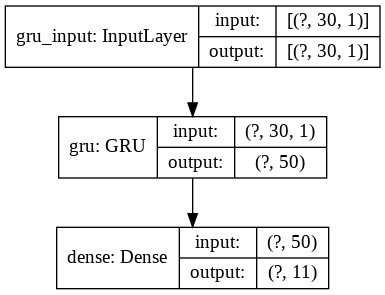

In [14]:
plot_model(model, to_file='topology.png',show_shapes=True)

In [16]:
model.save(f"simple-gru-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc.h5", save_format='.h5')
model.save(f"simple-gru-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc")

INFO:tensorflow:Assets written to: simple-gru-100maxepoch-k10fold-0.48624414491922385avgacc/assets
